# Project for brain classification using CNN model and augmentation.

## ****Import Libraries in this section****

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
seed = 0
import warnings
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
from sklearn.decomposition import KernelPCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

## **Load dataset**

Here we load dataset in X_train array and labels in y_label. 0 - No tumor 1 - Glioma tumor 2 - Meningioma tumor 3 - Pituitary tumor

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
IMG_SIZE = 255
x_train = []
y_label = []

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master'):
    print(dirname)
    for filename in filenames:
        im = cv2.imread(dirname+"/"+filename)
        img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        if 'no_tumor' in dirname:
            y_label.append(0)
            x_train.append(new_array)
        elif 'glioma_tumor' in dirname:
            y_label.append(1)
            x_train.append(new_array)
        elif 'meningioma_tumor' in dirname:
            y_label.append(2)
            x_train.append(new_array)
        elif 'pituitary_tumor' in dirname:
            y_label.append(3)
            x_train.append(new_array)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Testing
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Testing\glioma_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Testing\meningioma_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Testing\no_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Testing\pituitary_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Training
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Training\glioma_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Training\meningioma_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Training\no_tumor
C:/Users/0570/Downloads/Brain-Tumor-Classification-DataSet-master\Training\pituitary_tumor


In [5]:
x_train = np.array(x_train)
x_train.shape

(3264, 255, 255, 3)

In [6]:
y_label = np.array(y_label)
y_label = pd.get_dummies(y_label)
y_label.shape

(3264, 4)

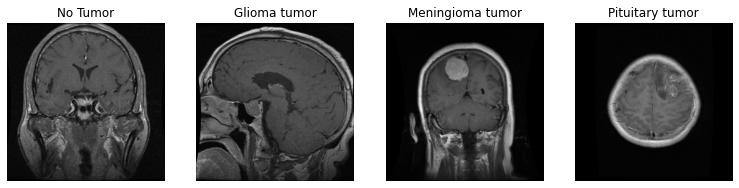

In [7]:
fig, axes = plt.subplots(ncols=4, figsize=(13,6))
title = ["No Tumor",
         "Glioma tumor",
         "Meningioma tumor",
         "Pituitary tumor"]
for i in range(4):
    rand_ind = np.random.randint(0, y_label[y_label==i].shape[0])
    axes[i].imshow(x_train[rand_ind])
    axes[i].set_title(title[i])
    axes[i].axis('off')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    x_train, y_label, test_size=0.3, random_state=seed
)

In [9]:
X_train.shape

(2284, 255, 255, 3)

## **Data Augmentation**

Adding tilt and shifting ranges for augmentation

In [10]:
train_datagen = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest'
                                  )

for i in range(0,2284):
    img_tensor = np.expand_dims(X_train[i], axis=0)
    pic = train_datagen.flow(img_tensor,batch_size =1, seed=0)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    X_train = np.append(X_train, [image_], axis=0)
print(image_.shape)

(255, 255, 3)


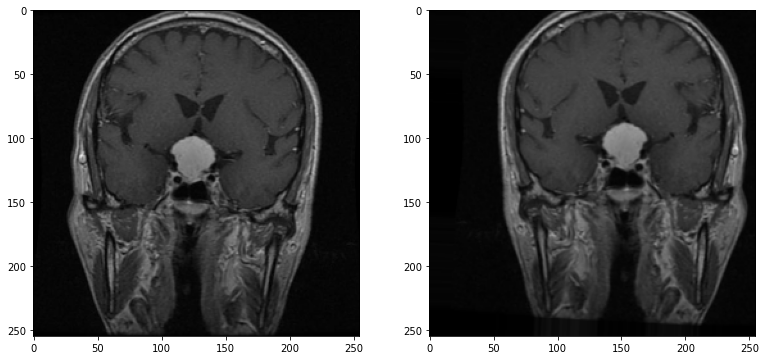

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(13,6))
axes[0].imshow(X_train[0])
axes[1].imshow(X_train[0+2284])

In [12]:
y_train = pd.concat([y_train,y_train])
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train

array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

## Train CNN with ReduceLROnPlateau on augmented data set

In [13]:
# Define the input layer
input_layer = keras.Input(shape=[X_train.shape[1],X_train.shape[2], X_train.shape[3]])

h1 = layers.Conv2D(64, kernel_size=(5, 5),padding = 'Same', activation="relu")(input_layer)
h1 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h1)
h1 = layers.Dropout(0.25)(h1)

h2 = layers.Conv2D(128, kernel_size=(3, 3),padding = 'Same', activation="relu")(h1)
h2 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h2)
h2 = layers.Dropout(0.25)(h2)

h3 = layers.Conv2D(128, kernel_size=(2, 2),padding = 'Same', activation="relu")(h2)
h3 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h3)
h3 = layers.Dropout(0.3)(h3)

h4 = layers.Conv2D(256, kernel_size=(2, 2),padding = 'Same', activation="relu")(h3)
h4 = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2))(h4)
h4 = layers.Dropout(0.3)(h4)

h4 = layers.Flatten()(h4)

h5 = layers.Dense(1024, activation="relu")(h4)
h5 = layers.Dropout(0.5)(h5)

h6 = layers.Dense(4, activation="softmax")(h5)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model = keras.Model(inputs=input_layer, outputs=h6)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 50  
batch_size = 40

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 255, 255, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 128)      0         
 2D)                                                         

In [15]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [16]:
model_result = model.fit(X_train, 
                         y_train, 
                         batch_size=batch_size,
                         epochs=epochs, 
                         validation_split=0.2,
                         callbacks=[reduce_lr])

Epoch 1/50
92/92 [==============================] - 781s 7s/step - loss: 74.0718 - accuracy: 0.3618 - val_loss: 1.3350 - val_accuracy: 0.4540 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 638s 7s/step - loss: 1.1028 - accuracy: 0.5186 - val_loss: 1.1543 - val_accuracy: 0.5142 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 638s 7s/step - loss: 0.9726 - accuracy: 0.5848 - val_loss: 1.0688 - val_accuracy: 0.5810 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 639s 7s/step - loss: 0.8476 - accuracy: 0.6494 - val_loss: 0.9078 - val_accuracy: 0.6105 - lr: 0.0010
Epoch 5/50
92/92 [==============================] - 640s 7s/step - loss: 0.7227 - accuracy: 0.7132 - val_loss: 0.8480 - val_accuracy: 0.6477 - lr: 0.0010
Epoch 6/50
92/92 [==============================] - 633s 7s/step - loss: 0.6378 - accuracy: 0.7504 - val_loss: 0.7051 - val_accuracy: 0.7057 - lr: 0.0010
Epoch 7/50
92/92 [==============================] - 634s 7s/step - loss: 0.

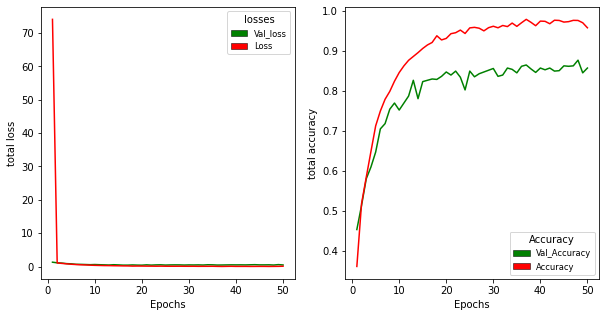

In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

metrics = model_result.history
epochs = np.linspace(1, 50, 50)
ax1.set(xlabel='Epochs', ylabel='total loss')
ax1.plot(epochs,metrics['val_loss'], color='g')
ax1.plot(epochs,metrics['loss'], color='r')
one = mpatches.Patch(facecolor='g', label='Val_loss', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='r', label = 'Loss', linewidth = 0.5, edgecolor = 'black')
ax1.legend(handles=[one, two], title="losses",
                    loc=1, fontsize='small', fancybox=True)

ax2.plot(epochs,metrics['val_accuracy'], color='g')
ax2.plot(epochs,metrics['accuracy'], color='r')
ax2.set(xlabel='Epochs', ylabel='total accuracy')
one = mpatches.Patch(facecolor='g', label='Val_Accuracy', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='r', label = 'Accuracy', linewidth = 0.5, edgecolor = 'black')
ax2.legend(handles=[one, two], title="Accuracy",
                    loc=4, fontsize='small', fancybox=True)

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [19]:
y_pred = model.predict(X_test)
arr = []
for item in y_pred:
    result = np.where(item == np.amax(item))
    arr.append(result[0][0])
y_pred_new = np.array(arr)
y_pred_new = pd.get_dummies(y_pred_new)
y_pred_new = y_pred_new.idxmax(axis=1)
y_test_new = pd.DataFrame(y_test)
y_test_new = y_test_new.idxmax(axis=1)
y_test_new

31/31 [==============================] - 35s 978ms/step


0      3
1      2
2      3
3      1
4      2
      ..
975    2
976    2
977    1
978    1
979    3
Length: 980, dtype: int64

In [20]:
print(classification_report(np.array(y_test_new), np.array(y_pred_new), target_names=["No Tumor",
                                                                                      "Glioma Tumor",
                                                                                      "Meningioma tumor",
                                                                                      "Pituitary tumor"]))

                  precision    recall  f1-score   support

        No Tumor       0.93      0.83      0.88       143
    Glioma Tumor       0.96      0.85      0.90       302
Meningioma tumor       0.82      0.94      0.88       270
 Pituitary tumor       0.95      0.99      0.97       265

        accuracy                           0.91       980
       macro avg       0.92      0.90      0.91       980
    weighted avg       0.92      0.91      0.91       980



In [22]:
filename="model.h5"
model.save(filename)

In [24]:
model.evaluate(X_test,y_test)

31/31 [==============================] - 30s 966ms/step - loss: 0.3172 - accuracy: 0.9102


[0.31718000769615173, 0.9102040529251099]

In [25]:
from tensorflow.keras.models import load_model
load_model = load_model(filename)
pred =  load_model.predict(X_test)
pred

31/31 [==============================] - 31s 979ms/step


array([[2.1962978e-07, 5.8374036e-04, 3.3625271e-05, 9.9938238e-01],
       [2.9887895e-03, 5.9801986e-04, 9.9588376e-01, 5.2943447e-04],
       [6.3337113e-10, 3.7816945e-09, 3.6825582e-05, 9.9996316e-01],
       ...,
       [7.0057183e-07, 1.3601661e-01, 7.5427884e-01, 1.0970388e-01],
       [3.5938321e-08, 1.7072406e-02, 9.8260421e-01, 3.2337013e-04],
       [5.6398242e-10, 1.1449308e-07, 4.1991496e-04, 9.9957997e-01]],
      dtype=float32)